Authors:
- Abdulaziz Alakooz : Github([@3koozy](https://github.com/3koozy)).
- Ahad Algrais : Github([@ahadalgrais](https://github.com/ahadalgrais)).
- Mujtaba Alghadeer : Github([@ghadeem](https://github.com/ghadeem)).

In [ ]:
# Prequisites / requirments:
!pip install segmentation-models-pytorch
!pip install git+https://github.com/IBM/ibm-cos-sdk-python.git
!pip install botocore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 7.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=9aeb4ec180ccdbe3ae206d3f3565ea1ad6e92cf2d33511ca1756e3569b0761da
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=dd31dea9f6c060c9ff922c835dbb02102055b0a7e4133f6896a35b76e7d3f5ae
  Stored in directory: /root/.cache/pip/w

In [ ]:
#import needed libraries:
import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import ibm_boto3
from botocore.client import Config
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import os
from matplotlib.colors import ListedColormap

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!nvidia-smi

Mon Mar 27 20:24:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# IBM Cloud Basics / S3 Storage Bucket

1- Create IBM Watson Studio Instance.

2- Create IBM Cloud storage S3 Bucket.

3- Upload Floodnet dataset to S3 bucket.

## 4- Access Floodnet dataset in IBM S3 Bucket:

The dataset we are using in this notebook is called FloodNet ([Find more info here](https://github.com/BinaLab/FloodNet-Supervised_v1.0)). It contains UAV captured images , which basically aim to help train models to detect flooded areas by solving scene segmentation task.

In [ ]:
Floodnet_client = ibm_boto3.client(
    service_name='s3',
    ibm_api_key_id='GkZ8taZhKfV0YSr-6PMjkOBDKZ9pXNbZGdV__BlV0IU2',
    ibm_service_instance_id='crn:v1:bluemix:public:cloud-object-storage:global:a/0ea459b190e84e6299997e670871a078:d7271cdb-8695-4b95-a7f5-f1d048bbb98f::',
    ibm_auth_endpoint='https://iam.cloud.ibm.com/identity/token',
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.us-south.cloud-object-storage.appdomain.cloud' #'https://s3.private.us-south.cloud-object-storage.appdomain.cloud'
)

In [ ]:
#collect training image keys:
objects1 = Floodnet_client.list_objects(Bucket='cloud-object-storage-sdaia-james-cos-standard-floodnet', Prefix="FloodNet/train/train-org-img/")["Contents"]
objects2 = Floodnet_client.list_objects(Bucket='cloud-object-storage-sdaia-james-cos-standard-floodnet', Prefix="FloodNet/train/train-org-img/", Marker="FloodNet/train/train-org-img/8182.jpg")["Contents"]

objects1_keys = [objects1[i]["Key"] for i in range(len(objects1))][1:]
# print(objects1_keys[:10])

objects2_keys = [objects2[i]["Key"] for i in range(len(objects2))]
# print(objects2_keys[:10])

object_keys = objects1_keys + objects2_keys
# print(object_keys)

#collect training image masks:
labels1 = Floodnet_client.list_objects(Bucket='cloud-object-storage-sdaia-james-cos-standard-floodnet', Prefix="FloodNet/train/train-label-img/")["Contents"]
labels2 = Floodnet_client.list_objects(Bucket='cloud-object-storage-sdaia-james-cos-standard-floodnet', Prefix="FloodNet/train/train-label-img/", Marker="FloodNet/train/train-label-img/8182_lab.png")["Contents"]

labels1_keys = [labels1[i]["Key"] for i in range(len(labels1))][1:]
# print(labels1_keys[:10])

labels2_keys = [labels2[i]["Key"] for i in range(len(labels2))]
# print(labels2_keys[:10])

label_keys = labels1_keys + labels2_keys
# print(label_keys)

In [ ]:
#collect test image keys:
objects_test = Floodnet_client.list_objects(Bucket='cloud-object-storage-sdaia-james-cos-standard-floodnet', Prefix="FloodNet/test/test-org-img/")["Contents"]

objects_test_keys = [objects_test[i]["Key"] for i in range(len(objects_test))][1:]
# print(objects1_keys[:10])

#collect test image masks:
labels_test = Floodnet_client.list_objects(Bucket='cloud-object-storage-sdaia-james-cos-standard-floodnet', Prefix="FloodNet/test/test-label-img/")["Contents"]

labels_test_keys = [labels_test[i]["Key"] for i in range(len(labels_test))][1:]
# print(labels1_keys[:10])

In [ ]:
class IBMS3Dataset(Dataset):
    """FloodNet dataset."""

    def __init__(self, s3_client, bucket_name, objects_list, labels_list, transform=None):
        """
        Args:
            s3_client (s3 client): s3 client used to fetch images from s3 bucket.
            bucket_name (string): name of an S3 bucket to be accessed.
            objects_list (list): list of image keys to be used with the s3 client.
            labels_list (list): list of segmentation image labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.s3_client = s3_client
        self.bucket_name = bucket_name
        self.objects_list = objects_list
        self.labels_list = labels_list
        self.transform = transform

    def __len__(self):
        return len(self.objects_list)

    def __getitem__(self, idx):
        image_bytes = self.s3_client.get_object(Bucket=self.bucket_name, Key=self.objects_list[idx])['Body']
        image = Image.open(BytesIO(image_bytes.read()))
        
        label_bytes = self.s3_client.get_object(Bucket=self.bucket_name, Key=self.labels_list[idx])['Body']
        label = Image.open(BytesIO(label_bytes.read()))
        
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        
        return image, label

# FloodNet UAV Captured imagery

## 1- Define Floodnet as Pytorch dataset and dataloaders:

In [ ]:
transform = transforms.Compose([transforms.PILToTensor(),
                                transforms.Resize((64,64))]) #transforms.PILToTensor()

floodnet_dataset_train = IBMS3Dataset(Floodnet_client, "cloud-object-storage-sdaia-james-cos-standard-floodnet", object_keys, label_keys, transform=transform)
floodnet_dataset_test = IBMS3Dataset(Floodnet_client, "cloud-object-storage-sdaia-james-cos-standard-floodnet", objects_test_keys, labels_test_keys, transform=transform)

In [ ]:
batch_size = 16

floodnet_dataloader_train = DataLoader(floodnet_dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
floodnet_dataloader_test = DataLoader(floodnet_dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

## 2- define and train our Pytorch segmentation model:

In [ ]:
def acc(label, predicted):
    seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
    return seg_acc

In [ ]:
N_EPOCHS = 3

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=10,                      # model output channels (number of classes in your dataset)
)

if str(device) == 'cuda':
        print("model is cuda")
        model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = smp.losses.DiceLoss('multiclass', from_logits=True)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
min_loss = torch.tensor(float('inf'))

os.makedirs('./saved_models', exist_ok=True)

model is cuda


In [ ]:
import copy

plot_losses = []
scheduler_counter = 0
best_model = None

for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(floodnet_dataloader_train):
      pred_mask = model(x.to(device).float())
      loss = criterion(pred_mask, y.to(device).type(torch.int64))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      print(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(floodnet_dataloader_train),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(floodnet_dataloader_test):
      with torch.no_grad():    
          pred_mask = model(x.to(device).float())  
      val_loss = criterion(pred_mask, y.to(device).type(torch.int64))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())
      
  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch, 
                                                                                                  np.mean(loss_list), 
                                                                                                  np.mean(acc_list), 
                                                                                                  np.mean(val_loss_list),
                                                                                                  np.mean(val_acc_list)))
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])

  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
    best_model = copy.deepcopy(model)

  if scheduler_counter > 5:
      lr_scheduler.step()
      print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
      scheduler_counter = 0

[Epoch 0/3] [Batch 0/91] [Loss: 0.940510 (0.940510)]
[Epoch 0/3] [Batch 1/91] [Loss: 0.846075 (0.893293)]
[Epoch 0/3] [Batch 2/91] [Loss: 0.928874 (0.905153)]
[Epoch 0/3] [Batch 3/91] [Loss: 0.715559 (0.857755)]
[Epoch 0/3] [Batch 4/91] [Loss: 0.910398 (0.868283)]
[Epoch 0/3] [Batch 5/91] [Loss: 0.879766 (0.870197)]
[Epoch 0/3] [Batch 6/91] [Loss: 0.787089 (0.858325)]
[Epoch 0/3] [Batch 7/91] [Loss: 0.887007 (0.861910)]
[Epoch 0/3] [Batch 8/91] [Loss: 0.666474 (0.840195)]
[Epoch 0/3] [Batch 9/91] [Loss: 0.759457 (0.832121)]
[Epoch 0/3] [Batch 10/91] [Loss: 0.755532 (0.825158)]
[Epoch 0/3] [Batch 11/91] [Loss: 0.713637 (0.815865)]
[Epoch 0/3] [Batch 12/91] [Loss: 0.765135 (0.811963)]
[Epoch 0/3] [Batch 13/91] [Loss: 0.613813 (0.797809)]
[Epoch 0/3] [Batch 14/91] [Loss: 0.800865 (0.798013)]
[Epoch 0/3] [Batch 15/91] [Loss: 0.815302 (0.799093)]
[Epoch 0/3] [Batch 16/91] [Loss: 0.779537 (0.797943)]
[Epoch 0/3] [Batch 17/91] [Loss: 0.804593 (0.798312)]
[Epoch 0/3] [Batch 18/91] [Loss: 0.789

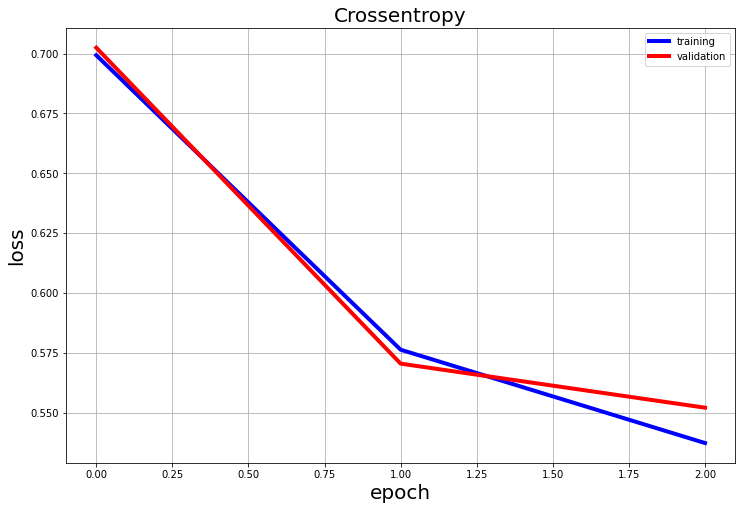

In [ ]:
# plot loss
plot_losses = np.array(plot_losses)
plt.figure(figsize=(12,8))
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title("Crossentropy", fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.savefig('loss_plots.png')

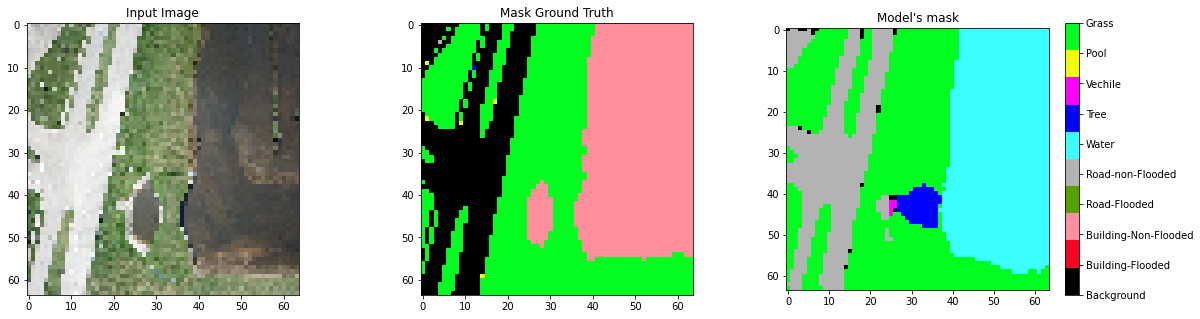

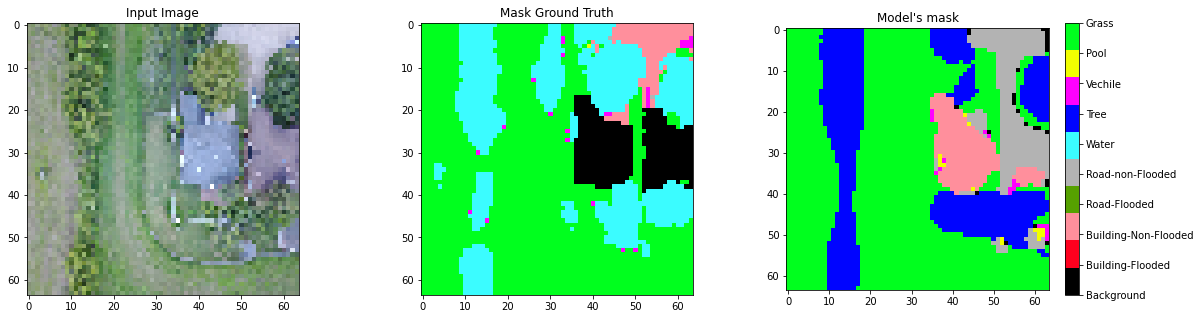

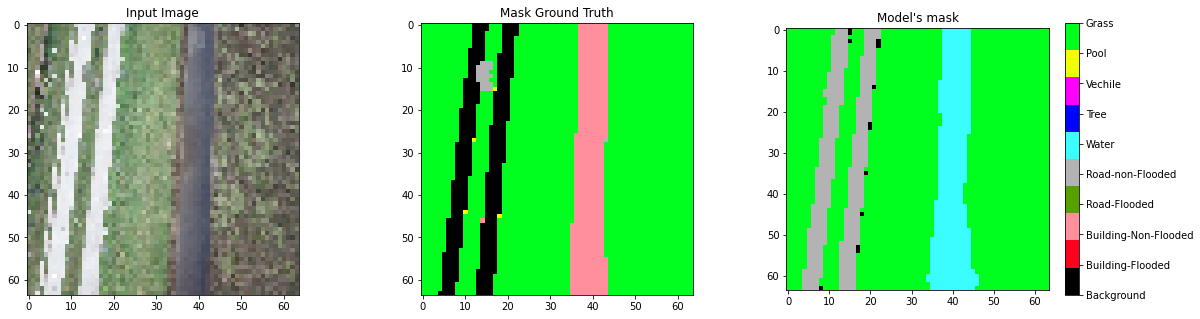

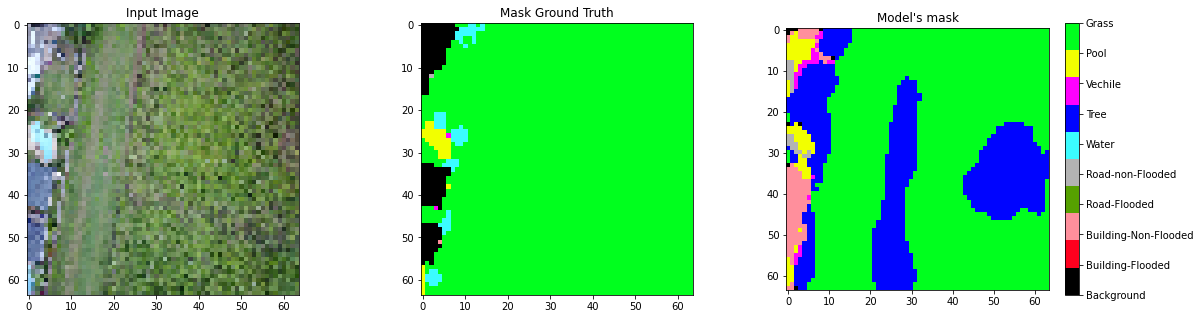

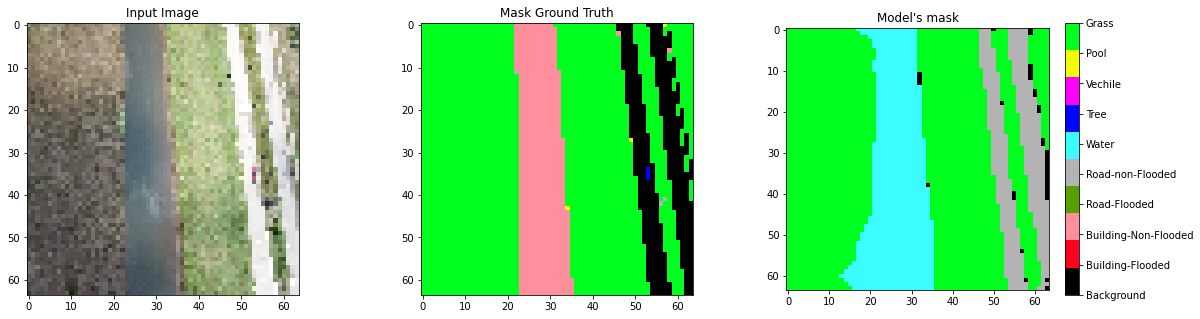

In [ ]:
# lets look at some samples
floodnet_dataloader_sample = DataLoader(floodnet_dataset_test, batch_size=1, shuffle=True, num_workers=0)
num_samples = 5

# Specify colors for each class using hex codes
class_colors = [
    "#000000", "#ff001e", "#ff8f9c", "#56a100",
    "#b3b3b3", "#3bfcff", "#0004ff", "#ff00ff",
    "#f2ff00", "#00ff1e"
]

class_names = [
    'Background', 'Building-Flooded', 'Building-Non-Flooded', 'Road-Flooded',
    'Road-non-Flooded', 'Water', 'Tree', 'Vechile',
    'Pool', 'Grass'
]

# Create a colormap with the given colors
colormap = ListedColormap(class_colors)
for i in range(num_samples):
    plt.figure(figsize=(20, 5))
    sample = next(iter(floodnet_dataloader_sample))
    model.eval()
    output = model(sample[0].float().to(device)).detach().type(torch.int64)
    plt.subplot(1,3,1)
    plt.title("Input Image")
    plt.imshow(sample[0][0].permute(1, 2, 0)) # for visualization we have to transpose back to HWC
    plt.subplot(1,3,2)
    plt.title("Mask Ground Truth")
    plt.imshow(sample[1].squeeze(), cmap=colormap)  # for visualization we have to remove 3rd dimension of mask
    plt.subplot(1,3,3)
    plt.title("Model's mask")
    plt.imshow(output.argmax(dim=1).squeeze().cpu(), cmap=colormap)  # for visualization we have to remove 3rd dimension of mask
    cbar = plt.colorbar(ticks=range(10), format='%1i', cmap=colormap)
    cbar.ax.set_yticklabels(class_names)

    plt.show()

## 3- Save best model to IBM S3 Bucket:

In [ ]:
#save best model
torch.save(best_model.state_dict(), 'best_model.pt')
Floodnet_client.upload_file('best_model.pt', 'abdulaziz-sdaia-floodnet-models', 'best_model.pt')

In [ ]:
#load best model:
Floodnet_client.download_file('abdulaziz-sdaia-floodnet-models', 'best_model.pt', 'downloaded_best_model.pt')
lbm = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=10,                      # model output channels (number of classes in your dataset)
)
lbm.load_state_dict(torch.load('downloaded_best_model.pt'))
lbm.eval()

#test loaded model:
plt.figure(figsize=(10, 5))
sample = floodnet_dataset_test[40]
output = lbm(sample[0].unsqueeze(dim=0).float()).detach().type(torch.int64)
plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(sample[0].permute(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,3,2)
plt.title("Mask Ground Truth")
plt.imshow(sample[1].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.subplot(1,3,3)
plt.title("Model's mask")
plt.imshow(output.argmax(dim=1).squeeze())  # for visualization we have to remove 3rd dimension of mask

plt.show()